# Benchmark structural regression 

In [198]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

In [667]:
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"

In [868]:
### parse trace files
def parse_trace(result_dir):
    f = os.path.basename(result_dir)
    name_trace = ".command.trace"
    trace = join(result_dir, name_trace)
    df = pd.read_csv(trace, sep = "=").T
    df = df.rename(index={'nextflow.trace/v2': f})
    return(df)

def split_name(df):
    df[["family", "method", "bucket_size", "dynamicX_label","dynamicX_val",
               "master_msa", "master_batch",
               "slave_msa", "slave_batch","tree"]] = df.name.str.split(".", expand = True)
    return(df)


### Collect all computation files across directories 
def get_computation_times(evaluation_dir, dataset, task, extralevel = False, splitname =False):
    # Extract trace files w/ corresponding alignments
    traces = pd.DataFrame()
    alignments_dir = join(evaluation_dir,task)
    for fam in listdir(alignments_dir):
        family_dir=join(alignments_dir, fam)
        
        # remove extra level if needed
        if extralevel == False:
            family_dir = alignments_dir
            
        for f in listdir(family_dir):
            result_dir = join(family_dir,f)
            if(os.path.isdir(result_dir)):
                df = parse_trace(result_dir)
                traces = traces.append(df)
                
        if extralevel == False:
            break
    # Trace files parsed
    traces = traces.reset_index(level=0)
    traces = traces.rename(columns={'index': 'name'})
    traces["benchmarking_dataset"] = dataset
    if splitname: 
        traces = split_name(traces)
    
    traces["task"] = task
    return(traces)

In [325]:
def add_families(trees_traces):
    trees_traces["family"] = trees_traces.name.str.split(".",expand=True)[0]
    trees_traces["tree_method"] = trees_traces.name.str.split(".",expand=True)[1]
    return(trees_traces)

#### Load datasets informations (Homfam + extHomfam)

In [869]:
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})
summary_homfam_exthomfam.head(2)

,family,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total,benchmarking_dataset
0,rvp,combined,93681,94.288554,22,133,rvp,xlarge,0.006405,homfam
1,zf-CCHH,combined,88345,23.251265,12,35,zf-CCHH,xlarge,0.016979,homfam


# <div style="text-align: center;"> <span align="center" style="color:blue">_________TREES_________</span> </div>


In [769]:
trees_traces_homfam = get_computation_times(join(evaluation_dir, "homfam"), "homfam", "trees", extralevel=True, splitname=False)
trees_traces_homfam = add_families(trees_traces_homfam)

trees_traces_exthomfam_v35 = get_computation_times(join(evaluation_dir, "extHomfam_v35-uniprot"), "extHomfam_v35-uniprot", "trees", extralevel=True, splitname=False)
trees_traces_exthomfam_v35 = add_families(trees_traces_exthomfam_v35)

trees_traces = pd.concat([trees_traces_homfam, trees_traces_exthomfam_v35])

stat_trees = pd.merge(trees_traces, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
stat_trees.head(2)

,name,realtime,%cpu,rchar,wchar,syscr,syscw,read_bytes,write_bytes,%mem,...,family,tree_method,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total
0,il8.FAMSA-parttree,81,600,138715,30817,142,22,1024000,32768,0,...,il8,FAMSA-parttree,combined,1073,63.762349,18,82,il8,small,1.025163
1,il8.FAMSA-medoid,379,829,138725,30822,142,22,1024000,32768,0,...,il8,FAMSA-medoid,combined,1073,63.762349,18,82,il8,small,1.025163


In [796]:
# Remove outliers for visualization 
stat_trees_nooutlier = stat_trees.sort_values(by=['realtime'], ascending=False).iloc[10:]
stat_trees_nooutlier = stat_trees_nooutlier.sort_values(by=['realtime'])
outliers = stat_trees.sort_values(by=['realtime'], ascending=False).iloc[:10]
outliers.size_group

729    xlarge
624    xlarge
908    xlarge
218    xlarge
916     large
352    xlarge
883    medium
235      huge
248    xlarge
578      huge
Name: size_group, dtype: object

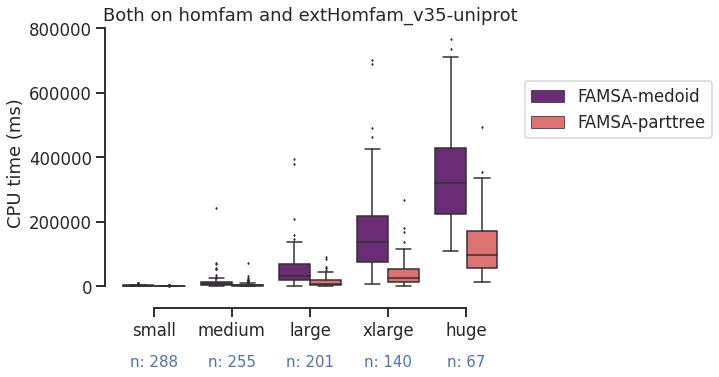

In [797]:

sns.set_theme(style="ticks")
sns.set_context("talk")

# Load the example tips dataset
f, ax = plt.subplots(figsize=(7, 5))
df = stat_trees_nooutlier
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="size_group", y="realtime",
            hue="tree_method", palette = "magma",
            data=df, linewidth=1.5, fliersize = 1.5, dodge = True)

# Calculate number of obs per group & median to position labels
nobs = df['size_group'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            -250000,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='b')
 


ax.set(ylabel='CPU time (ms)', xlabel='', title = "Both on homfam and extHomfam_v35-uniprot")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)

sns.despine(offset=10, trim=True)
#f, ax = plt.subplots(figsize=(7, 7))
#sns.scatterplot(data=stat_trees, y="realtime", x="n_sequences", hue="tree_method",
#                palette = "magma",style = "benchmarking_dataset", s = 30)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#ax.set(ylabel='CPU time (ms)', xlabel='number of sequences')


# <div style="text-align: center;"> <span align="center" style="color:red">_________Computation times_________</span> </div>

In [897]:
# ---------- EXTRACT SEQUENCES ---------------
traces_extracted_sequences_homfam = get_computation_times(join(evaluation_dir, "homfam"), "homfam", "seqs_extracted")
# ---------- AF2 PREDICTIONS -------------------------
traces_af2_homfam = get_computation_times(join(evaluation_dir, "homfam"), "homfam", "structures/colabfold")
# ---------- ALIGNMENTS -------------------------
traces_alignments_homfam = get_computation_times(join(evaluation_dir, "homfam"), "homfam", "alignments", extralevel=True)
# ---------- CONCATENATE AL OF THEM IN ONE ---------------
traces = pd.concat([traces_extracted_sequences_homfam,traces_alignments_homfam], ignore_index=True)

In [898]:
traces

,name,realtime,%cpu,rchar,wchar,syscr,syscw,read_bytes,write_bytes,%mem,vmem,rss,peak_vmem,peak_rss,vol_ctxt,inv_ctxt,benchmarking_dataset,task
0,rnasemam.dynamic.100.dynamicX.100000.tcoffee_m...,845,230,809338,202350,763,187,1631232,446464,0,37460,3744,37460,3744,36,3,homfam,seqs_extracted
1,seatoxin.dynamic.100.dynamicX.100000.tcoffee_m...,1426,72,127181,21249,223,33,1553408,40960,0,37460,3744,37460,3744,65,3,homfam,seqs_extracted
2,bowman.dynamic.100.dynamicX.100000.tcoffee_msa...,474,503,626401,107391,1026,243,1582080,499712,0,37460,3744,37460,3744,27,2,homfam,seqs_extracted
3,seatoxin.dynamic.100.dynamicX.100000.tcoffee_m...,1166,68,127390,21261,223,33,1502208,40960,0,35512,2924,36536,2924,50,6,homfam,seqs_extracted
4,cyt3.dynamic.100.dynamicX.100000.tcoffee_msa.1...,764,301,830227,146519,1263,300,1598464,610304,0,35512,2928,36536,2928,46,5,homfam,seqs_extracted
5,scorptoxin.dynamic.100.dynamicX.100000.tcoffee...,1374,165,604659,98187,999,234,1582080,475136,0,69744,37500,69748,37500,96,54,homfam,seqs_extracted
6,hip.dynamic.100.dynamicX.100000.tcoffee_msa.10...,391,203,224710,48025,298,56,1565696,106496,0,37096,4608,37988,4608,75,3,homfam,seqs_extracted
7,rnasemam.regressive.100.FAMSA.FAMSA-medoid,5638,627,12982918,903252,7911,987,3685376,1847296,0,121300,74244,121304,74244,103,16,homfam,alignments
8,cyt3.regressive.100.FAMSA.FAMSA-medoid,4454,751,13165034,1682615,7732,994,3652608,2600960,0,119524,72564,119528,72564,131,14,homfam,alignments
9,scorptoxin.regressive.100.FAMSA.FAMSA-medoid,3165,723,9123232,443172,5887,757,3636224,1175552,0,119172,72192,119176,72192,78,15,homfam,alignments


# <div style="text-align: center;"> <span align="center" style="color:balck">_________Load Evaluation_________</span> </div>

In [635]:
# Load AF2 scores
af2 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/02_summary_af2.csv")
af2_grouped = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/03_summary_af2_grouped.csv")

In [899]:
def get_evaluation(evaluation_dir, dataset, splitname = True, method = "dynamic"):
    scores = evaluation_dir + "/evaluation/CSV/"+method+".scores.csv"
    scores_df = pd.read_csv(scores, sep=";", header = None).iloc[: , :-1]
    scores_df.set_axis(list(["name", "sp","tc", "column"]), axis=1, inplace=True)
    if splitname:
        if method == "dynamic": 
            scores_df[["family", "method", "bucket_size", "dynamicX_label","dynamicX_val",
                       "master_msa", "master_batch",
                       "slave_msa", "slave_batch","tree"]] = scores_df.name.str.split(".", expand = True)
        elif method == "regressive":
            scores_df[["family", "method", "bucket_size",
                       "master_msa","tree"]] = scores_df.name.str.split(".", expand = True)            
    scores_df["benchmarking_dataset"] = dataset
    return(scores_df)

def get_evaluation_all(evaluation_dir, dataset):
    dynamic = get_evaluation(join(evaluation_dir,dataset), dataset, method = "dynamic")
    regressive = get_evaluation(join(evaluation_dir,dataset), dataset, method = "regressive")
    df = pd.concat([dynamic, regressive])
    return(df)

In [900]:
scores_df = get_evaluation_all(evaluation_dir, "homfam")

# <div style="text-align: center;"> <span align="center" style="color:lightgrey">_________MERGE_________</span> </div>

In [901]:
stats = pd.merge(scores_df, traces, on = ["name","benchmarking_dataset"])
stats = pd.merge(stats, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
stats.head()

,name,sp,tc,column,family,method,bucket_size,dynamicX_label,dynamicX_val,master_msa,...,inv_ctxt,task,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total
0,seatoxin.dynamic.100.dynamicX.100000.tcoffee_m...,70.8,26.5,25.7,seatoxin,dynamic,100,dynamicX,100000,tcoffee_msa,...,6,seqs_extracted,combined,93,43.634409,34,50,seatoxin,small,5.376344
1,seatoxin.dynamic.100.dynamicX.100000.tcoffee_m...,70.8,26.5,25.7,seatoxin,dynamic,100,dynamicX,100000,tcoffee_msa,...,1730,alignments,combined,93,43.634409,34,50,seatoxin,small,5.376344
2,seatoxin.regressive.100.FAMSA.FAMSA-medoid,81.2,46.9,47.0,seatoxin,regressive,100,NaN,NaN,FAMSA,...,15,alignments,combined,93,43.634409,34,50,seatoxin,small,5.376344
3,bowman.regressive.100.FAMSA.FAMSA-medoid,90.7,71.4,74.4,bowman,regressive,100,NaN,NaN,FAMSA,...,33,alignments,combined,499,26.144289,14,71,bowman,small,1.002004
4,scorptoxin.regressive.100.FAMSA.FAMSA-medoid,94.7,80.8,85.7,scorptoxin,regressive,100,NaN,NaN,FAMSA,...,15,alignments,combined,363,53.256198,22,69,scorptoxin,small,2.203857


# <div style="text-align: center;"> <span align="center" style="color:blue">_________VISUALIZE_________</span> </div>

In [650]:
# --------------   TODO -----------------
# 1 - Does the dynamic improve accuracy ? 
# a. plot all 3 metrics (SUM etc) vs the number of sequences (Dynamic + Regressive on FAMSA)
# 2 - At which computational loss? 
# b. plot all 3 metrics (SUM etc) vs the CPU time (aligner only) (Dynamic + Regressive on FAMSA)
# c. plot all 3 metrics (SUM etc) vs the CPU time (aligner only AND aligner + extract + prediction) (Dynamic + Regressive on FAMSA)
# 3 - confront gain in accuracy? Accuracy Dynamic vs Accuracy regressive
# 4 - cnfront loss in speed - cpu time dynamic vs regressive

In [902]:
# Only keep one entry (the one for the alignments) per family 
# Otherwise we would have multiple entries as we have multiple  
stats_unique = stats[stats.task == "alignments"]
stats_unique

,name,sp,tc,column,family,method,bucket_size,dynamicX_label,dynamicX_val,master_msa,...,inv_ctxt,task,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total
1,seatoxin.dynamic.100.dynamicX.100000.tcoffee_m...,70.8,26.5,25.7,seatoxin,dynamic,100,dynamicX,100000,tcoffee_msa,...,1730,alignments,combined,93,43.634409,34,50,seatoxin,small,5.376344
2,seatoxin.regressive.100.FAMSA.FAMSA-medoid,81.2,46.9,47.0,seatoxin,regressive,100,NaN,NaN,FAMSA,...,15,alignments,combined,93,43.634409,34,50,seatoxin,small,5.376344
3,bowman.regressive.100.FAMSA.FAMSA-medoid,90.7,71.4,74.4,bowman,regressive,100,NaN,NaN,FAMSA,...,33,alignments,combined,499,26.144289,14,71,bowman,small,1.002004
4,scorptoxin.regressive.100.FAMSA.FAMSA-medoid,94.7,80.8,85.7,scorptoxin,regressive,100,NaN,NaN,FAMSA,...,15,alignments,combined,363,53.256198,22,69,scorptoxin,small,2.203857
5,rnasemam.regressive.100.FAMSA.FAMSA-medoid,86.8,63.4,75.2,rnasemam,regressive,100,NaN,NaN,FAMSA,...,16,alignments,combined,498,120.072289,62,140,rnasemam,small,1.204819
6,cyt3.regressive.100.FAMSA.FAMSA-medoid,67.8,29.7,32.4,cyt3,regressive,100,NaN,NaN,FAMSA,...,14,alignments,combined,385,92.306494,52,127,cyt3,small,1.558442


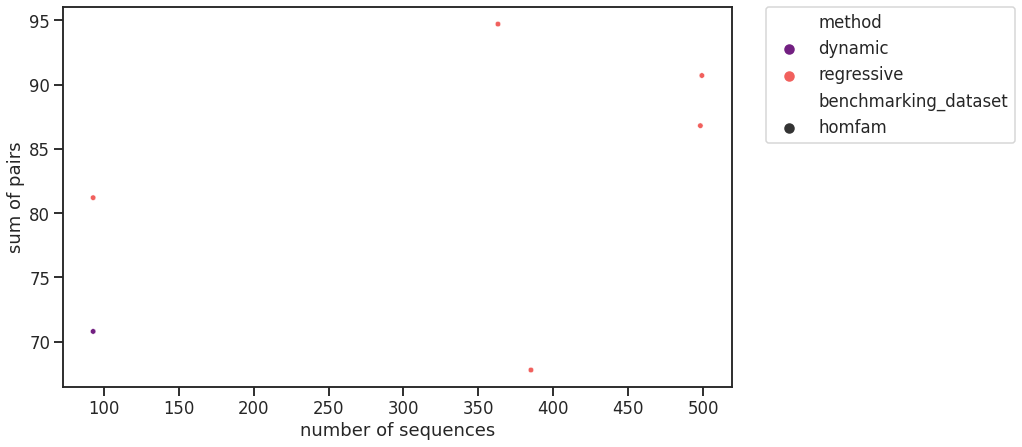

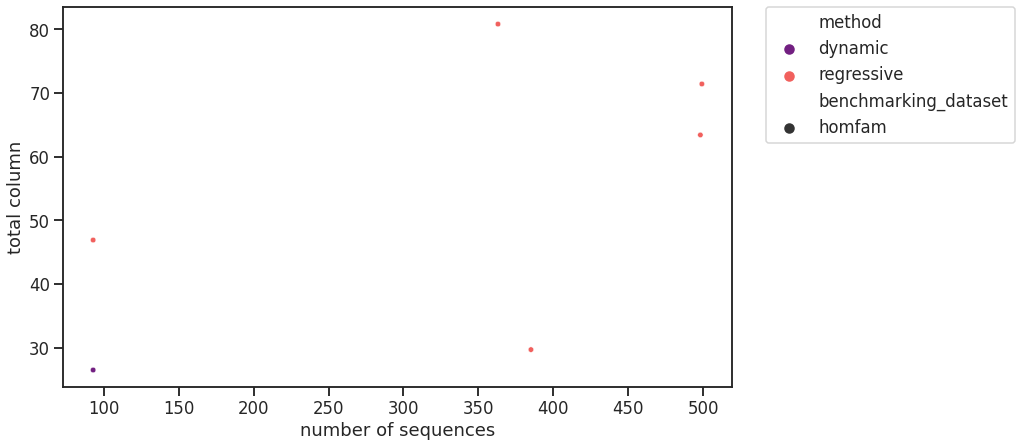

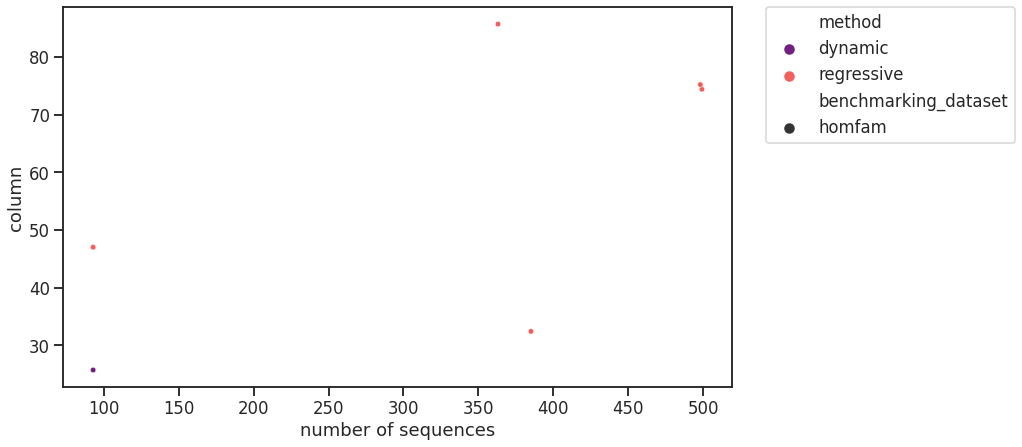

In [903]:
# 1 - Does the dynamic improve accuracy ? 
# a. plot all 3 metrics (SUM etc) vs the number of sequences (Dynamic + Regressive on FAMSA)
sns.set_context("talk")
metrics = [["sp", "sum of pairs"], ["tc", "total column"], ["column", "column"]]

for metric in metrics:
    f, ax = plt.subplots(figsize=(12, 7))
    sns.scatterplot(data=stats_unique, y=metric[0], x="n_sequences", hue="method",
                    palette = "magma",style = "benchmarking_dataset", s = 30)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel=metric[1], xlabel='number of sequences')

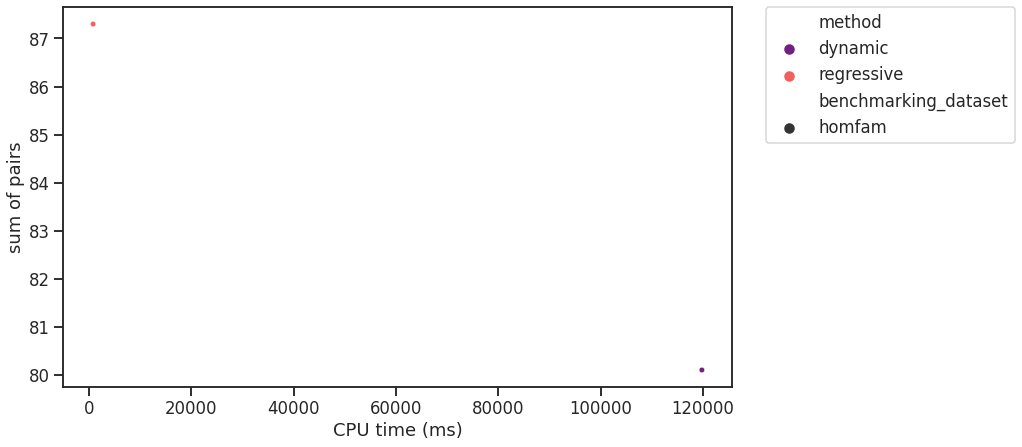

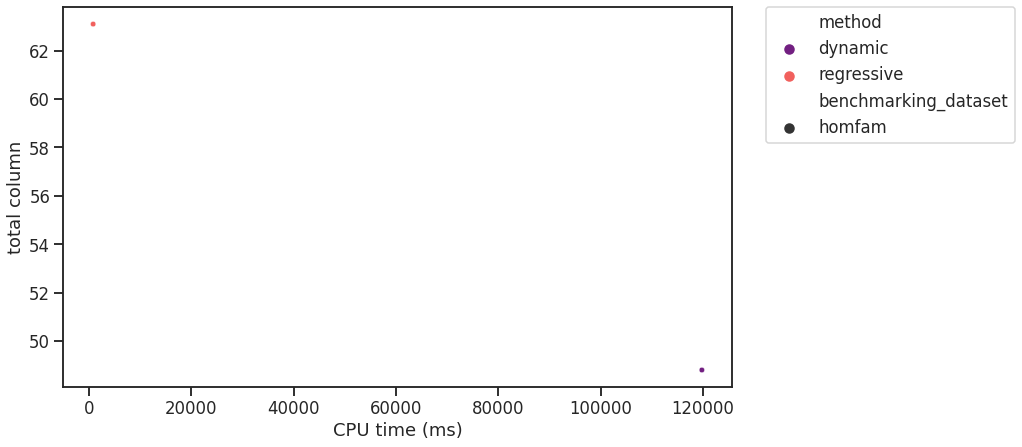

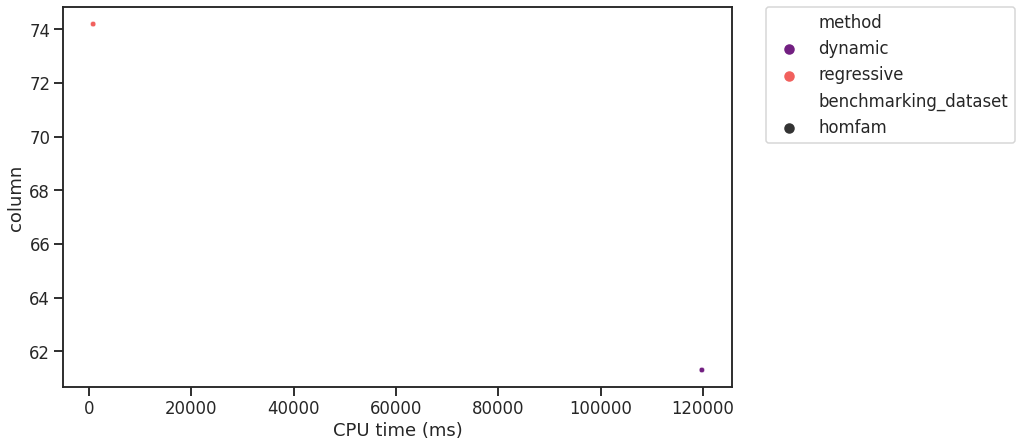

In [879]:
# 2 - At which computational loss? 
# b. plot all 3 metrics (SUM etc) vs the CPU time (aligner only) (Dynamic + Regressive on FAMSA)
for metric in metrics:
    f, ax = plt.subplots(figsize=(12, 7))
    sns.scatterplot(data=stats_unique, y=metric[0], x="realtime", hue="method",
                    palette = "magma",style = "benchmarking_dataset", s = 30)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel=metric[1], xlabel='CPU time (ms)')

In [ ]:
# c. plot all 3 metrics (SUM etc) vs the CPU time (aligner only AND aligner + extract + prediction) (Dynamic + Regressive on FAMSA)
